# Tute 1 - Filtering data and Regularised Regression

Go through the tute with Python

## NOTE:
If you followed along with the code from the tute, not that this code has been updated
to correct a few errors, mainly with how the date formatted for the BCC data.

Main lesson is don't assume anything (including that Pandas will infer the date format correctly; learn from my mistakes :) )

In [1]:
# unlike MATLAB, core Python is limited to a few data types and built in methods
# Thats ok though, because there is a tonne of open source packages that do
# pretty much everything we need, we just need to import them

# numpy handles pretty much anything that is a number/vector/matrix/array
import numpy as np
# pandas handles dataframes (exactly the same as tables in Matlab)
import pandas as pd
# matplotlib emulates Matlabs plotting functionality
import matplotlib.pyplot as plt
# stats models is a package that is going to perform the regression analysis
from statsmodels import api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
# os allows us to manipulate variables on out local machine, such as paths and environment variables
import os
# self explainatory, dates and times
from datetime import datetime, date
# a helper package to help us iterate over objects
import itertools

First step is to combine all of the data from the spreadsheets. Want to combine temperature, rainfall and solar data from the same date and have them all on the same row entry.
Looking at one of the data sets, we see that the year, month and day are separated across different columns.
Want to have a single column to allow us to compare dates. This function can be applied to each
row in a dataframe using the built-in `apply()` method.

In [2]:
# Create single datetime object from year, month and day
def create_date(row):
    # create string with date it format Y:m:d
  return datetime.strptime('{:04d}/{:02d}/{:02d}'.format(row.Year, row.Month, row.Day),
                           '%Y/%m/%d')

In [3]:
# Q1. Load in all the data
def load_bom(root_dir='/home/ethan/cab420/tutes/cab420/tute1_data/BOM'):
  """load in the BOM data and concatenate it all"""
  rain = pd.read_csv(os.path.join(root_dir, 'IDCJAC0009_040913_1800_Data.csv'))
  temp = pd.read_csv(os.path.join(root_dir, 'IDCJAC0010_040913_1800_Data.csv'))
  solar = pd.read_csv(os.path.join(root_dir, 'IDCJAC0016_040913_1800_Data.csv'))
  
  # want all the date ranges to be the same
  rain = rain[(rain.Year >= 2014) & (rain.Year <= 2018)]
  temp = temp[(temp.Year >= 2014) & (temp.Year <= 2018)]
  solar = solar[(solar.Year >= 2014) & (solar.Year <= 2018)]
  # create a datetime object for each row, and store it in the Date column
  rain['Date'] = rain.apply(create_date, axis=1)
  temp['Date'] = temp.apply(create_date, axis=1)
  solar['Date'] = solar.apply(create_date, axis=1)
  # now merge them all based on the date, so will create a single Date
  # column that has them all in
  bom_combined = pd.merge(rain, temp, on='Date')
  bom_combined = pd.merge(bom_combined, solar, on='Date')
  return bom_combined



In [4]:
# load it in, and then lets have a look at it to make sure it is all ok
bom = load_bom()
print(bom.head())

  Product code_x  Bureau of Meteorology station number_x  Year_x  Month_x  \
0     IDCJAC0009                                   40913    2014        1   
1     IDCJAC0009                                   40913    2014        1   
2     IDCJAC0009                                   40913    2014        1   
3     IDCJAC0009                                   40913    2014        1   
4     IDCJAC0009                                   40913    2014        1   

   Day_x  Rainfall amount (millimetres)  \
0      1                            0.0   
1      2                            0.0   
2      3                            1.0   
3      4                            0.0   
4      5                            0.0   

   Period over which rainfall was measured (days) Quality_x       Date  \
0                                             1.0         N 2014-01-01   
1                                             1.0         N 2014-01-02   
2                                             1.0       

In [5]:
# looks like there are some repeated columns (from the year/month/day)
#lets get rid of those
print(bom.columns.values)

['Product code_x' 'Bureau of Meteorology station number_x' 'Year_x'
 'Month_x' 'Day_x' 'Rainfall amount (millimetres)'
 'Period over which rainfall was measured (days)' 'Quality_x' 'Date'
 'Product code_y' 'Bureau of Meteorology station number_y' 'Year_y'
 'Month_y' 'Day_y' 'Maximum temperature (Degree C)'
 'Days of accumulation of maximum temperature' 'Quality_y' 'Product code'
 'Bureau of Meteorology station number' 'Year' 'Month' 'Day'
 'Daily global solar exposure (MJ/m*m)']


In [6]:
bom = bom.drop(['Year', 'Month', 'Day',
                'Year_x', 'Month_x', 'Day_x',
                'Year_y', 'Month_y', 'Day_y'], axis=1)
bom.head()

,Product code_x,Bureau of Meteorology station number_x,Rainfall amount (millimetres),Period over which rainfall was measured (days),Quality_x,Date,Product code_y,Bureau of Meteorology station number_y,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality_y,Product code,Bureau of Meteorology station number,Daily global solar exposure (MJ/m*m)
0,IDCJAC0009,40913,0.0,1.0,N,2014-01-01,IDCJAC0010,40913,30.6,1.0,Y,IDCJAC0016,40913,31.2
1,IDCJAC0009,40913,0.0,1.0,N,2014-01-02,IDCJAC0010,40913,31.8,1.0,Y,IDCJAC0016,40913,23.4
2,IDCJAC0009,40913,1.0,1.0,N,2014-01-03,IDCJAC0010,40913,34.5,1.0,Y,IDCJAC0016,40913,29.6
3,IDCJAC0009,40913,0.0,1.0,N,2014-01-04,IDCJAC0010,40913,38.7,1.0,Y,IDCJAC0016,40913,30.5
4,IDCJAC0009,40913,0.0,1.0,N,2014-01-05,IDCJAC0010,40913,33.6,1.0,Y,IDCJAC0016,40913,15.7


In [7]:
# now want to load in the BCC data and see which columns are available in all of
# the different data sets
def load_bcc(root_dir='/home/ethan/cab420/tutes/cab420/tute1_data/BCCCyclewayCounts'):
  """load in the BCC dataset and combine them"""
  bcc_2014 = pd.read_csv(os.path.join(root_dir, 'bike-ped-auto-counts-2014.csv'))
  bcc_2015 = pd.read_csv(os.path.join(root_dir, 'bike-ped-auto-counts-2015.csv'))
  bcc_2016 = pd.read_csv(os.path.join(root_dir, 'bike-ped-auto-counts-2016.csv'))
  bcc_2017 = pd.read_csv(os.path.join(root_dir, 'bike-ped-auto-counts-2017.csv'))
  bcc_2018 = pd.read_csv(os.path.join(root_dir, 'bike-ped-auto-counts-2018.csv'))
  # make sure the date is the correct format
  # this is important, don't assume that Python or pandas will determine the
  # format correctly for you (talking from experience, learn from my mistakes)
  bcc_2014.Date = pd.to_datetime(bcc_2014.Date, format='%d/%m/%Y')
  bcc_2015.Date = pd.to_datetime(bcc_2015.Date, format='%d/%m/%Y')
  bcc_2016.Date = pd.to_datetime(bcc_2016.Date, format='%d/%m/%Y')
  bcc_2017.Date = pd.to_datetime(bcc_2017.Date, format='%d/%m/%Y')
  bcc_2018.Date = pd.to_datetime(bcc_2018.Date, format='%d/%m/%Y')
  # lets get the column values, and see which are consistent across them all
  # itertools is a helper module to help us convert the list of dataframe column
  # values (a list of lists) to one big flattened out list.
  # This flattened lists could have repeated entries
  all_columns_repeated = list(itertools.chain(*(
    bcc_2014.columns.values, bcc_2015.columns.values,
    bcc_2016.columns.values, bcc_2017.columns.values,
    bcc_2018.columns.values)))
  # creating a set of these column values  will remove duplicates
  all_columns = set(all_columns_repeated)
  # now lets perform the intersection of this set with each set of the column
  # values from each data set.
  # this will tell us which columns are common to every data set
  common_column = all_columns.intersection(bcc_2014.columns.values, bcc_2015.columns.values,
                                           bcc_2016.columns.values, bcc_2017.columns.values,
                                           bcc_2018.columns.values)
  # now lets get just the common columns from each data frame, and then
  # concatenate them all
  bcc_2014 = bcc_2014[common_column]
  bcc_2015 = bcc_2015[common_column]
  bcc_2016 = bcc_2016[common_column]
  bcc_2017 = bcc_2017[common_column]
  bcc_2018 = bcc_2018[common_column]
  # now concatenate them all (concat vertically)
  bcc = pd.concat([bcc_2014, bcc_2015, bcc_2016,
                   bcc_2017, bcc_2018])
  return bcc


In [8]:
bcc = load_bcc()
bcc.head()

,Story Bridge West Pedestrian Inbound,North Brisbane Bikeway Mann Park Windsor Pedestrian Outbound,Story Bridge East Pedestrian Outbound,Kedron Brook Bikeway Lutwyche,Bishop Street Cyclists Inbound,Granville Street Bridge Pedestrians Outbound,Kedron Brook Bikeway Lutwyche Cyclists Outbound,Ekibin Park Pedestrians Outbound,Ekibin Park Pedestrians Inbound,Bicentennial Bikeway Pedestrians Outbound,...,North Brisbane Bikeway Mann Park Windsor Pedestrian Inbound,Schulz Canal Bridge Pedestrians Outbound,Kedron Brook Bikeway Lutwyche Pedestrians Outbound,Riverwalk Cyclists Outbound,Story Bridge West Pedestrian Outbound,Kedron Brook Bikeway Mitchelton Pedestrian Inbound,North Brisbane Bikeway Mann Park Windsor Cyclists Inbound,Unnamed: 1,Jack Pesch Bridge Cyclists Outbound,Riverwalk Pedestrians Inbound
0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1326.0,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0:00,NaN,NaN
1,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2133.0,...,NaN,28.0,NaN,NaN,0.0,NaN,NaN,0:00,NaN,NaN
2,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1867.0,...,NaN,23.0,NaN,NaN,0.0,NaN,NaN,0:00,NaN,NaN
3,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1522.0,...,NaN,17.0,NaN,NaN,0.0,NaN,NaN,0:00,NaN,NaN
4,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2102.0,...,NaN,32.0,NaN,NaN,0.0,NaN,NaN,0:00,NaN,NaN


In [9]:
# now we can combine (merge) both the BOM and BCC dataframe
# again, want to merge using the date to make sure eveything is aligned and
# organised properly
# First, want to convert the Date column to a format consistent with the BOM data
bcc.Date = pd.to_datetime(bcc.Date)
combined = pd.merge(bom, bcc, on='Date')

In [10]:
print(combined.shape)
print(combined.head())

(1826, 66)


  Product code_x  Bureau of Meteorology station number_x  \
0     IDCJAC0009                                   40913   
1     IDCJAC0009                                   40913   
2     IDCJAC0009                                   40913   
3     IDCJAC0009                                   40913   
4     IDCJAC0009                                   40913   

   Rainfall amount (millimetres)  \
0                            0.0   
1                            0.0   
2                            1.0   
3                            0.0   
4                            0.0   

   Period over which rainfall was measured (days) Quality_x       Date  \
0                                             1.0         N 2014-01-01   
1                                             1.0         N 2014-01-02   
2                                             1.0         N 2014-01-03   
3                                             1.0         N 2014-01-04   
4                                             1.0   

# Q2 - Regularised Regression

In [11]:
# want to find samples that have a small amount of data, as we want to initially
# use as many samples as possible
# will remove some columns that, we don't actually need (aren't covariates)
# such as the BOM station number, etc.
to_drop = ['Product code_x', 'Bureau of Meteorology station number_x',
           'Product code_y', 'Bureau of Meteorology station number_y',
           'Product code', 'Bureau of Meteorology station number',
           'Period over which rainfall was measured (days)',
           'Days of accumulation of maximum temperature',
           'Quality_x', 'Quality_y']
#print(combined.columns.values)
combined = combined.drop(to_drop, axis=1)
print('combined shape = {}'.format(combined.shape))

combined shape = (1826, 56)


In [12]:
# now find columns/features/covariates that have a suitable amount of data,
# lets say 300 first
threshold = 300
columns_to_remove = []
for column in combined.columns.values:
  if np.sum(combined[column].isna()) > 300:
    # add this column to the list that should be removed
    columns_to_remove.append(column)
print(columns_to_remove)
print(len(columns_to_remove))    
# now lets remove them
combined = combined.drop(columns_to_remove, axis=1)
print(combined.shape)

['Kedron Brook Bikeway Lutwyche', 'Bishop Street Cyclists Inbound', 'Granville Street Bridge Pedestrians Outbound', 'Kedron Brook Bikeway Lutwyche Cyclists Outbound', 'Ekibin Park Pedestrians Outbound', 'Ekibin Park Pedestrians Inbound', 'Granville Street Bridge Cyclists Outbound', 'Jack Pesch Bridge Pedestrians Outbound', 'Story Bridge West Cyclists Outbound', 'Kedron Brook Bikeway Mitchelton Pedestrian Outbound', 'Ekibin Park Cyclists Outbound', 'Jack Pesch Bridge Cyclists Inbound', 'Bishop Street Cyclists Outbound', 'Granville Street Bridge Cyclists Inbound', 'Bishop Street Pedestrians Inbound', 'Kedron Brook Bikeway Mitchelton Cyclist Inbound', 'Kedron Brook Bikeway Lutwyche Cyclists Inbound', 'Granville Street Bridge Pedestrians Inbound', 'North Brisbane Bikeway Mann Park Windsor Cyclists Outbound', 'Riverwalk Pedestrians Outbound', 'Kedron Brook Bikeway Mitchelton', 'Bishop Street Pedestrians Outbound', 'Ekibin Park Cyclists Inbound', 'Jack Pesch Bridge Pedestrians Inbound', 'Riv

In [13]:
# now drop any rows that contain a Nan, and get rid of them
print(np.sum(combined.isna(), axis=1))
print(np.sum(np.sum(combined.isna(), axis=1) > 0))
nans = combined.isna()
print(type(nans))
nans.to_csv('nans.csv')
combined_filtered = combined.dropna(axis=0)
# saving the final data set
combined_filtered.to_csv('combined.csv')
# lets have a look at the final data set
print(combined_filtered.head())
print('Final dataset shape = {}'.format(combined_filtered.shape))
print(combined.iloc[11, :])

0       3
1       3
2       3
3       3
4       3
       ..
1821    0
1822    0
1823    0
1824    0
1825    0
Length: 1826, dtype: int64
404
<class 'pandas.core.frame.DataFrame'>


     Rainfall amount (millimetres)       Date  Maximum temperature (Degree C)  \
169                            0.0 2014-06-19                            20.3   
170                            5.8 2014-06-20                            22.5   
171                            0.0 2014-06-21                            25.6   
172                            5.2 2014-06-22                            24.2   
173                            0.2 2014-06-23                            24.1   

     Daily global solar exposure (MJ/m*m)  \
169                                   8.0   
170                                   9.1   
171                                  12.9   
172                                  13.0   
173                                  13.6   

     Story Bridge West Pedestrian Inbound  \
169                                   0.0   
170                                   0.0   
171                                   0.0   
172                                   0.0   
173              

In [14]:
# split into train/test split
train = combined_filtered[combined_filtered.Date < datetime(year=2017, month=1, day=1)]
val = combined_filtered[((combined_filtered.Date >= datetime(year=2017, month=1, day=1)) &
                        (combined_filtered.Date < datetime(year=2018, month=1, day=1)))]
test = combined_filtered[((combined_filtered.Date >= datetime(year=2018, month=1, day=1)) &
                          (combined_filtered.Date < datetime(year=2019, month=1, day=1)))]
print('num train = {}'.format(train.shape[0]))
print('val train = {}'.format(val.shape[0]))
print('test train = {}'.format(test.shape[0]))

num train = 888
val train = 276
test train = 258


Model 1 RMSE = 623.3791739360698
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     113.1
Date:                Wed, 04 Mar 2020   Prob (F-statistic):          4.59e-118
Time:                        12:03:52   Log-Likelihood:                -6899.6
No. Observations:                 888   AIC:                         1.382e+04
Df Residuals:                     880   BIC:                         1.385e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        739.22

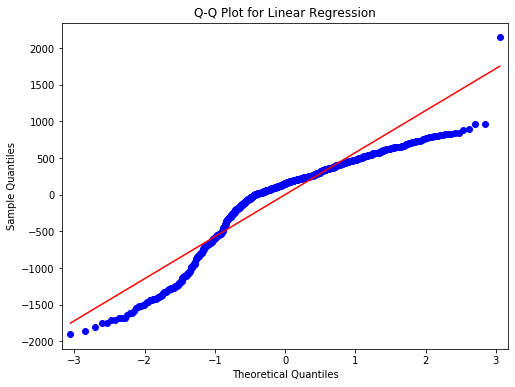

In [15]:
# now perform linear regression using Ordinary Least Squares
# want to use all weather data from the BOM
X_bom = ['Rainfall amount (millimetres)',
         'Daily global solar exposure (MJ/m*m)',
         'Maximum temperature (Degree C)']
# want to use all variables cyclist inbound variables
X_bcc = [x for x in train.columns.values if 'Cyclists Inbound' in x]
# remove the response variable from here
X_bcc.remove('Bicentennial Bikeway Cyclists Inbound')
# combine this list of variables together by just extending the
# BOM data with the BCC data
X_variables = X_bom + X_bcc
Y_variable = 'Bicentennial Bikeway Cyclists Inbound'
Y_train = np.array(train[Y_variable], dtype=np.float64)
X_train = np.array(train[X_variables], dtype=np.float64)
# want to add a constant to the model (the y-axis intercept)
X_train = sm.add_constant(X_train)
# also creating validation data
Y_val = np.array(val[Y_variable], dtype=np.float64)
X_val = np.array(val[X_variables], dtype=np.float64)
X_val = sm.add_constant(X_val)
# create the linear model
model = sm.OLS(Y_train, X_train)
# fit the model without any regularisation
model_1_fit = model.fit()
pred = model_1_fit.predict(X_val)
print('Model 1 RMSE = {}'.format(
  np.sqrt(mean_squared_error(Y_val, model_1_fit.predict(X_val)))))
print(model_1_fit.summary())
print(model_1_fit.params)
fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(model_1_fit.resid, ax=ax, line='s')
plt.title('Q-Q Plot for Linear Regression')
plt.show()

Our initial residual plot looks pretty bad. The wonky trend in our residuals suggests that the i.i.d. assumption made when performing ordinary least squares is bad. This implies that the variance is not common within our data samples, meaning that our dataset is heteroskedastic (don't need to worry too much about the implications of this for this class, but the concepts of homoskedasticity and heteroskedasticity are important for successful application of stats/ML models).

Despite this poor model, we will continue on looking to see if we can tidy things up within a OLS model.


[[ 1.         -0.1373654  -0.03216845 -0.28375855 -0.08392224 -0.12134364
  -0.16416081 -0.16317026]
 [-0.1373654   1.          0.64749344  0.52359272  0.1162428   0.24915125
   0.35713766  0.09517715]
 [-0.03216845  0.64749344  1.          0.44445062  0.11422163  0.21496214
   0.25038631  0.02452469]
 [-0.28375855  0.52359272  0.44445062  1.          0.30354061  0.35673773
   0.53424962  0.39493691]
 [-0.08392224  0.1162428   0.11422163  0.30354061  1.         -0.25427468
   0.5092007   0.54449222]
 [-0.12134364  0.24915125  0.21496214  0.35673773 -0.25427468  1.
   0.34952993  0.22037637]
 [-0.16416081  0.35713766  0.25038631  0.53424962  0.5092007   0.34952993
   1.          0.45741757]
 [-0.16317026  0.09517715  0.02452469  0.39493691  0.54449222  0.22037637
   0.45741757  1.        ]]


<Figure size 432x288 with 0 Axes>

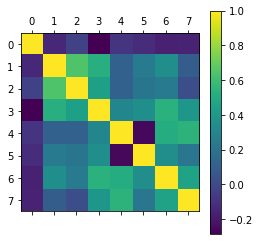

In [16]:
# lets see if any variables aren't explicitly correlated with our response variable.
all_variables = X_variables + ['Bicentennial Bikeway Cyclists Inbound']
corr_coeffs = train[all_variables].corr()
plt.figure()
plt.matshow(corr_coeffs)
plt.colorbar()
print(np.array(corr_coeffs))

In [17]:
# looks like there is little evidence in our dataset to identify a linear
# relationship (correlation) between variables (1 and 2) with our response.
# So, lets remove them and see what happens
to_remove = [X_variables[1], X_variables[2]]
print('Variables to remove -> {} and {}'.format(to_remove[0], to_remove[1]))
train = train.drop([X_variables[1], X_variables[2]], axis=1)
# also want to remove these variable names from the X_variable list
X_variables.remove(to_remove[0])
X_variables.remove(to_remove[1])
print(X_variables)
# now lets create a new model and perform regression on that
X_train = np.array(train[X_variables], dtype=np.float64)
# want to add a constant to the model (the y-axis intercept)
X_train = sm.add_constant(X_train)
# also creating validation data
Y_val = np.array(val[Y_variable], dtype=np.float64)
X_val = np.array(val[X_variables], dtype=np.float64)
X_val = sm.add_constant(X_val)
# now make the model and fit it
model_2 = sm.OLS(Y_train, X_train)
# fit the model without any regularisation
model_2_fit = model_2.fit()
pred = model_2_fit.predict(X_val)
print('Model 1 RMSE = {}'.format(
  np.sqrt(mean_squared_error(Y_val, model_2_fit.predict(X_val)))))
print(model_2_fit.summary())
print(model_2_fit.params)

Variables to remove -> Daily global solar exposure (MJ/m*m) and Maximum temperature (Degree C)
['Rainfall amount (millimetres)', 'Schulz Canal Bridge Cyclists Inbound', 'Story Bridge East Cyclists Inbound', 'Story Bridge West Cyclists Inbound', 'North Brisbane Bikeway Mann Park Windsor Cyclists Inbound']
Model 1 RMSE = 589.0180774318336
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     140.1
Date:                Wed, 04 Mar 2020   Prob (F-statistic):          2.12e-109
Time:                        12:03:53   Log-Likelihood:                -6924.9
No. Observations:                 888   AIC:                         1.386e+04
Df Residuals:                     882   BIC:                         1.389e+04
Df Model:                    

## Trying some regularisation now (for next weeks content)
Will compare L1 and L2 Regression now, using the refined model from before.

In [18]:
# fit the model with L1 regularisation (Lasso Regression)
# have a look at the statsmodel documentation for info on how we specify
# the regularisation parameters
# basically if the L1_wt param is 1, will be Lasso
# if L1_wt = 0, will be Ridge
alpha = 1.0
model_l1_fit = model_2.fit_regularized(alpha=alpha, L1_wt=1)
pred = model_l1_fit.predict(X_val)
print('L1: alpha = {},  RMSE = {}'.format(
  alpha, np.sqrt(mean_squared_error(Y_val, model_l1_fit.predict(X_val)))))

# now lets try L2
model_l2_fit = model_2.fit_regularized(alpha=alpha, L1_wt=0)
pred = model_l2_fit.predict(X_val)
print('L2: alpha = {},  RMSE = {}'.format(
  alpha, np.sqrt(mean_squared_error(Y_val, model_l2_fit.predict(X_val)))))


L1: alpha = 1.0,  RMSE = 589.137748794
L2: alpha = 1.0,  RMSE = 588.951674045983


Not much between them, but we only tried a few different regularisation coeffs.
Lets do some cross validation with different reg parameters

In [19]:
# try different L1 and L2 params
# making a variable that will store the best RMSE
# making it super large so will definitely be overwritten
best_rmse = 10e12
best_alpha = []
best_L1_L2 = []

# lets try a bunch of different ranges of alpha for L1 and L2
alpha_list = np.linspace(0.1, 5.0, 20)
# list to say whether we used L1 or L2
L1_L2_list = [0, 1]

for L1_L2 in L1_L2_list:
  for alpha in alpha_list:
    model_cross_fit = model_2.fit_regularized(alpha=alpha, L1_wt=0)
    pred = model_cross_fit.predict(X_val)
    rmse = np.sqrt(mean_squared_error(Y_val, model_cross_fit.predict(X_val)))
    print('L1_L2 = {},  alpha = {},  RMSE = {}'.format(L1_L2, alpha, rmse))
    # if this is the model with the lowest RMSE, lets save it
    if rmse < best_rmse:
      best_rmse = rmse
      best_alpha = alpha
      best_L1_L2 = L1_L2

print('\nBest Model: L1_L2 = {}, alpha = {}, RMSE = {}'.format(
  best_L1_L2, best_alpha, best_rmse))

L1_L2 = 0,  alpha = 0.1,  RMSE = 588.984606085982
L1_L2 = 0,  alpha = 0.35789473684210527,  RMSE = 588.9750615893155
L1_L2 = 0,  alpha = 0.6157894736842106,  RMSE = 588.9660024054714
L1_L2 = 0,  alpha = 0.8736842105263158,  RMSE = 588.9564445073951
L1_L2 = 0,  alpha = 1.1315789473684212,  RMSE = 588.9466691135386
L1_L2 = 0,  alpha = 1.3894736842105266,  RMSE = 588.936796242534
L1_L2 = 0,  alpha = 1.6473684210526318,  RMSE = 588.9268815049898
L1_L2 = 0,  alpha = 1.905263157894737,  RMSE = 588.9169536902782
L1_L2 = 0,  alpha = 2.1631578947368424,  RMSE = 588.9070290586033
L1_L2 = 0,  alpha = 2.421052631578948,  RMSE = 588.8971174246851
L1_L2 = 0,  alpha = 2.678947368421053,  RMSE = 588.8872250233652
L1_L2 = 0,  alpha = 2.936842105263158,  RMSE = 588.8773559754427
L1_L2 = 0,  alpha = 3.1947368421052635,  RMSE = 588.8675130894502
L1_L2 = 0,  alpha = 3.452631578947369,  RMSE = 588.8576983250479
L1_L2 = 0,  alpha = 3.710526315789474,  RMSE = 588.8479130734514
L1_L2 = 0,  alpha = 3.9684210526

Looking at this, we can see that the model with the lowest RMSE used L2 regularisation with and $\alpha = 5.0$ and an RMSE of 588.799.

It is important to note that the improvements was pretty small for all cases here. Regardless, lets have a look at the final performance of the model on the test set.

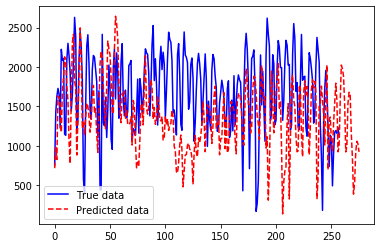

In [20]:
# also creating validation data
Y_test = np.array(test[Y_variable], dtype=np.float64)
X_test = np.array(test[X_variables], dtype=np.float64)
X_test = sm.add_constant(X_val)
model_best = model_2.fit_regularized(alpha=5.0, L1_wt=1)
test_eval = model_best.predict(X_test)

plt.figure()
plt.plot(Y_test, 'b', label='True data')
plt.plot(test_eval, 'r--', label='Predicted data')
plt.legend()

looks like the model still isn't very good but we expected this, given that we new from our first model that a simple linear regression with an i.i.d. assumption was bad. We can still see this from the residuals plot for the best model.

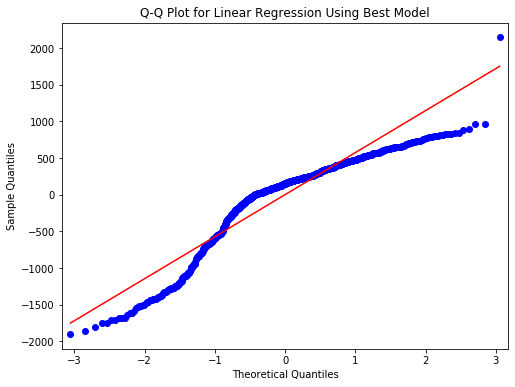

In [21]:
fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(model_1_fit.resid, ax=ax, line='s')
plt.title('Q-Q Plot for Linear Regression Using Best Model')
plt.show()

Still a wonky trend in this Q-Q plot of the residuals (heteroskedasticity). 
Our model could be included by accomodating for this change in variance, but usually requires significant more
domain expertise to implement successfully.

This is a big take home message as well: domain expertise is *REALLY* important. Without it, your modelling scheme is likely going to be pretty average at best. When you get more comfortable with ML, you can begin to better incorporate this into your modelling assumptions, or better yet, can move to a Bayesian approach and apply the domain expertise of your industry partners in the form of a prior probability! (not covered in this unit, but anyone keen on ML should check it ouyt eventually)